# Splink tests

Bringing Sarah's code in leads to some inevitable bugs with our versions of packages, and I need a place to work out how some of these functions work.

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import duckdb
import pandas as pd
import random
import datetime

import altair as alt
alt.renderers.enable("mimetype")

from cmf.models import model_train as ld
from cmf.features.clean_complex import clean_comp_names
from cmf.config import stopwords
from cmf.config import settings
from cmf.features.clean_basic import (
    remove_notnumbers_leadingzeroes,
    clean_company_name,
    array_except,
    array_intersect,
    list_join_to_string,
)

from splink.duckdb.linker import DuckDBLinker
from splink.charts import save_offline_chart

RendererRegistry.enable('mimetype')

## From Sarah's tests

I'm just aiming to replicate her code so I can explore it a bit and see why it's not running for me.

Sarah's comments:

Read in Companies House data, return `company_number`, `postcodes` and `company_name` split into: 'unusual' tokens, most common 3 tokens and most common 4 to 6 tokens.

In [3]:
df_ch = ld.comp_house_read()

/opt/conda/envs/lead_generation_experiments/lib/python3.9/site-packages/pandas/io/sql.py:1410: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  meta = MetaData(self.connectable, schema=schema)


In [4]:
df_ch_clean = ld.clean_numbers_and_names(df_ch)
df_ch_clean.reset_index(inplace=True)
df_ch_clean.rename(columns={"index": "unique_id"}, inplace=True)

In [5]:
df_ch_clean.describe(include='all')

,unique_id,comp_num_clean,name_unusual_tokens,secondary_name_unusual_tokens,names_tokens_stopwords,postcode,postcode_alt,name_unusual_tokens_first5,name_unusual_tokens_last5,postcode_area
count,5.350528e+06,5350528,5350454,5350519,5350528,5350528,0.0,5350454,5350454,5265568
unique,NaN,5160761,5191154,506352,747,947538,NaN,601612,576680,488
top,NaN,1,property,,limited,,NaN,consu,vices,N
freq,NaN,22,29,4840406,4416784,81701,NaN,120371,177742,176447
mean,2.675264e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.544565e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.337632e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.675264e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.012895e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_dh = ld.data_hub_read()

In [7]:
df_dh_clean = ld.clean_numbers_and_names(df_dh)
df_dh_clean.reset_index(inplace=True)
df_dh_clean.rename(columns={"index": "unique_id"}, inplace=True)

In [8]:
df_dh_clean.describe(include='all')

,unique_id,comp_num_clean,name_unusual_tokens,secondary_name_unusual_tokens,names_tokens_stopwords,postcode,postcode_alt,name_unusual_tokens_first5,name_unusual_tokens_last5,postcode_area
count,176050.000000,90742,176046,176048,176050,176050,0.0,176046,176046,115526
unique,NaN,89757,168517,33476,412,90830,NaN,54777,53102,271
top,NaN,,barclays,,limited,,NaN,consu,tions,EC
freq,NaN,143,34,140244,81278,12088,NaN,2099,3319,5251
mean,88024.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,50821.401783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,44012.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,88024.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,132036.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sarah's comments:

Instantiate the linker

In [9]:
linker = DuckDBLinker(
    [df_dh_clean, df_ch_clean],
    settings,
    input_table_aliases=["datahub", "companies_house"],
)

Sarah's comments:

This is how you do a deterministic link. It uses whatever rules you specify in 'blocking_rules_to_generate_predictions'

`linker.deterministic_link().as_pandas_dataframe()`

Determine probability two random records match i.e. the prior. Should admit very few (none if possible) false positives. [Linker docs](https://moj-analytical-services.github.io/splink/linkerest.html#splink.linker).

`Linker.estimate_probability_two_random_records_match`

This assumption is important to what we think 'a company is'. If just using equality on name, we - for instance - think astrazeneca cambridge and astrazeneca macclesfield are 'the same' comp may need revisiting / alternative models building.

In [36]:
df_dh_clean.name_unusual_tokens.sample(5)
df_ch_clean.name_unusual_tokens.sample(5)

10798      coop genossenschaft gruppe
169844                  mango scripts
109134                   qnap systems
69510                          cypfer
88599     architects bradley steffian
Name: name_unusual_tokens, dtype: object

4428412       dark grimsby kitchen
2217747         ostereo publishing
5139079      distribution symmetry
2203595    bovingdon court orchard
832055              bargains nifty
Name: name_unusual_tokens, dtype: object

In [14]:
linker.estimate_probability_two_random_records_match(
    "l.name_unusual_tokens = r.name_unusual_tokens",
    recall=0.7,
)

Probability two random records match is estimated to be  1.89e-07.
This means that amongst all possible pairwise record comparisons, one in 5,302,807.68 are expected to match.  With 941,960,454,400 total possible comparisons, we expect a total of around 177,634.29 matching pairs


Sarah's comments:

But let's do probabilistic linkage instead. Increased `max_pairs` so that the model more likely to encounter the required comparison levels.

NOTE: random sampling and can't set seed anymore

In [44]:
linker.estimate_u_using_random_sampling(max_pairs=1e7)

----- Estimating u probabilities using random sampling -----
u probability not trained for comp_num_clean - Exact match (comparison vector value: 2). This usually means the comparison level was never observed in the training data.
u probability not trained for postcode_area - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - comp_num_clean (some m values are not trained).
    - postcode_area (some u values are not trained, some m values are not trained).


That warning is because we've got a bunch of values in Companies House that aren't in Data Hub, and vice versa.

Should we clean these? Could provide weird signal.

In [43]:
random.sample(
    list(set(df_dh_clean.postcode_area).difference(df_ch_clean.postcode_area)),
    5
)

['KIGALI', 'BFPO', 'BHI', 'BJL', 'BROOKHILL']

Sarah's comments:

If we can treat company number as a partially-completed label we can estimate the m values from the numbers.

In [45]:
df_dh_clean.comp_num_clean.sample(5)
df_ch_clean.comp_num_clean.sample(5)

133969        NaN
165627    9307691
152270        NaN
89588     4917626
25141         NaN
Name: comp_num_clean, dtype: object

4349781     1931158
4718797     5505973
17037      14224009
1971377     6070287
3807590    13628591
Name: comp_num_clean, dtype: object

In [47]:
random.sample(
    list(set(df_dh_clean.comp_num_clean).intersection(df_ch_clean.comp_num_clean)),
    5
)

['1370190', '11095559', '7277274', '10604962', '7109059']

In [48]:
linker.estimate_m_from_label_column("comp_num_clean")

---- Estimating m probabilities using from column comp_num_clean -----
m probability not trained for comp_num_clean - Jaro_winkler_similarity >= 0.75 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
m probability not trained for comp_num_clean - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.
m probability not trained for postcode_area - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.

Your model is not yet fully trained. Missing estimates for:
    - comp_num_clean (some m values are not trained).
    - postcode_area (some u values are not trained, some m values are not trained).


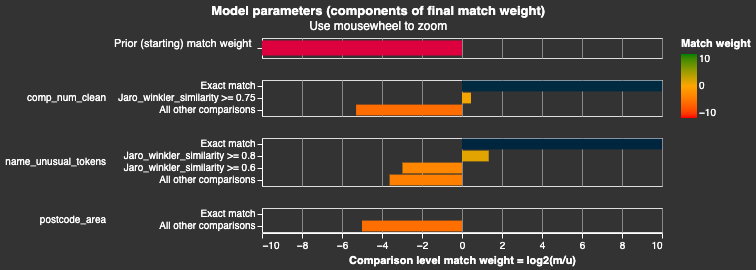

In [54]:
linker.match_weights_chart()

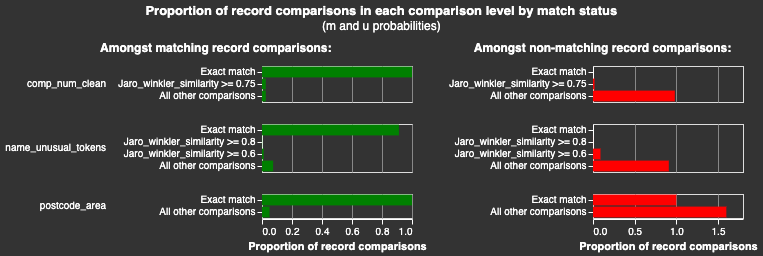

In [55]:
linker.m_u_parameters_chart()

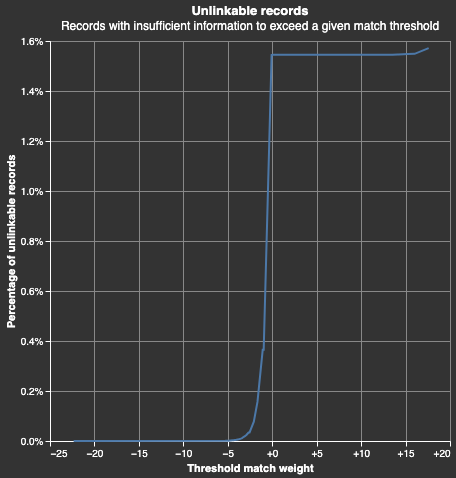

In [56]:
linker.unlinkables_chart()

In [57]:
predictions = linker.predict(threshold_match_probability=0.1)


 -- WARNING --
You have called predict(), but there are some parameter estimates which have neither been estimated or specified in your settings dictionary.  To produce predictions the following untrained trained parameters will use default values.
Comparison: 'comp_num_clean':
    m values not fully trained
Comparison: 'postcode_area':
    m values not fully trained
Comparison: 'postcode_area':
    u values not fully trained


In [58]:
df_predict = predictions.as_pandas_dataframe()
df_predict.sample(5)

,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,comp_num_clean_l,comp_num_clean_r,gamma_comp_num_clean,tf_comp_num_clean_l,tf_comp_num_clean_r,bf_comp_num_clean,bf_tf_adj_comp_num_clean,name_unusual_tokens_l,name_unusual_tokens_r,gamma_name_unusual_tokens,tf_name_unusual_tokens_l,tf_name_unusual_tokens_r,bf_name_unusual_tokens,bf_tf_adj_name_unusual_tokens,postcode_area_l,postcode_area_r,gamma_postcode_area,bf_postcode_area,name_unusual_tokens_first5_l,name_unusual_tokens_first5_r,match_key
15770,20.303244,0.999999,companies_house,datahub,1908008,95326,5575376,5575376,2,3.675612e-07,3.675612e-07,4.948061e+06,0.549839,ietg,ietg,3,3.618927e-07,3.618927e-07,9.073085e+06,0.27795,LS,LS,1,1.0,ietg,ietg,0
87400,-1.657230,0.240726,companies_house,datahub,752630,34441,6315791,NaN,-1,1.837806e-07,NaN,1.000000e+00,1.000000,medinet,medinet,3,5.428390e-07,5.428390e-07,9.073085e+06,0.18530,N,NaN,-1,1.0,medin,medin,1
64978,20.303244,0.999999,companies_house,datahub,4609396,102136,3534846,3534846,2,3.675612e-07,3.675612e-07,4.948061e+06,0.549839,lakeinvest,lakeinvest,3,3.618927e-07,3.618927e-07,9.073085e+06,0.27795,LA,LA,1,1.0,lakei,lakei,0
77176,20.303244,0.999999,companies_house,datahub,560761,133888,40892,40892,2,3.675612e-07,3.675612e-07,4.948061e+06,0.549839,alloys ireland,alloys ireland,3,3.618927e-07,3.618927e-07,9.073085e+06,0.27795,ML,ML,1,1.0,alloy,alloy,0
21550,20.303244,0.999999,companies_house,datahub,307789,44422,9899234,9899234,2,3.675612e-07,3.675612e-07,4.948061e+06,0.549839,alliance cyber defence,alliance cyber defence,3,3.618927e-07,3.618927e-07,9.073085e+06,0.27795,E,E,1,1.0,allia,allia,0


In [ ]:
clusters = linker.cluster_pairwise_predictions_at_threshold(predictions, threshold_match_probability=0.5)

In [ ]:
df_cluster = clusters.as_pandas_dataframe()
df_cluster.sample(5)

## Blocking rules

I've pretty much got Sarah's code working, but it currently takes 45 mins to run the whole pipeline end to end, with the bulk of that time being `predict`, which takes 41 mins.

Splink is very, very clear about tweaking performance via blocking [in the tutorial](https://moj-analytical-services.github.io/splink/demos/03_Blocking.html):

> Blocking rules are the most important determinant of the performance of your linkage job.

We need to investigate how to optimise this, especially as we move into using more than two datasets.

To reiterate the goals of this process, our rules need to:

1. Eliminate enough non-matching comparison pairs so your record linkage job is small enough to compute 
2. Eliminate as few truly matching pairs as possible (ideally none)

So let's get to it.

Let's start with the rules in Sarah's code, many of which were commented out:

* `"l.comp_num_clean = r.comp_num_clean"`
* `"l.name_unusual_tokens = r.name_unusual_tokens"`
* `"l.name_unusual_tokens_first5 = r.name_unusual_tokens_first5"`
* `"l.name_unusual_tokens_last5 = r.name_unusual_tokens_last5"`
* `"l.secondary_name_unusual_tokens = r.secondary_name_unusual_tokens"`
* `"l.secondary_name_unusual_tokens = r.name_unusual_tokens"`
* `"r.secondary_name_unusual_tokens = l.name_unusual_tokens"`
*  TODO: blocking rule on first token name_unusual_tokens?

Note that Splink will generate all comparison pairs that meet ANY of these rules. So as unique values rise, so do the amount of things that must be compared.

In [11]:
settings_2 = {"link_type": "link_only"}

linker_2 = DuckDBLinker(
    [df_dh_clean, df_ch_clean],
    settings_2,
    input_table_aliases=["datahub", "companies_house"],
)

In [16]:
blocking_rules = {
    'blocking_rule_1': "l.comp_num_clean = r.comp_num_clean",
    'blocking_rule_2': "l.name_unusual_tokens = r.name_unusual_tokens",
    'blocking_rule_3': "l.name_unusual_tokens_first5 = r.name_unusual_tokens_first5",
    'blocking_rule_4': "l.name_unusual_tokens_last5 = r.name_unusual_tokens_last5",
    'blocking_rule_5': "l.secondary_name_unusual_tokens = r.secondary_name_unusual_tokens",
    'blocking_rule_6': "l.secondary_name_unusual_tokens = r.name_unusual_tokens",
    'blocking_rule_7': "r.secondary_name_unusual_tokens = l.name_unusual_tokens"
}

In [35]:
rule_counts = {
    'rule': [],
    'count': []
}

for rule in blocking_rules.keys():
    print(f'{datetime.datetime.now()}: Evaluating {rule}')
    
    count = linker_2.count_num_comparisons_from_blocking_rule(blocking_rules[rule])
    
    print(f'{datetime.datetime.now()}: Finished evaluating {rule}')
    
    rule_counts['rule'].append(rule)
    rule_counts['count'].append(count)


2023-06-16 14:03:09.506043: Evaluating blocking_rule_1
2023-06-16 14:03:09.560729: Finished evaluating blocking_rule_1
2023-06-16 14:03:09.560762: Evaluating blocking_rule_2
2023-06-16 14:03:09.588338: Finished evaluating blocking_rule_2
2023-06-16 14:03:09.588370: Evaluating blocking_rule_3
2023-06-16 14:11:22.168216: Finished evaluating blocking_rule_3
2023-06-16 14:11:22.168313: Evaluating blocking_rule_4
2023-06-16 14:23:40.211857: Finished evaluating blocking_rule_4
2023-06-16 14:23:40.211948: Evaluating blocking_rule_5


SplinkException: Error executing the following sql for table `__splink__analyse_blocking_rule` (__splink__analyse_blocking_rule_d7bbebb07):
CREATE TABLE __splink__analyse_blocking_rule_d7bbebb07 AS
(
  WITH __splink__df_concat AS (
    SELECT
      'datahub' AS source_dataset,
      "unique_id",
      "comp_num_clean",
      "name_unusual_tokens",
      "secondary_name_unusual_tokens",
      "names_tokens_stopwords",
      "postcode",
      "postcode_alt",
      "name_unusual_tokens_first5",
      "name_unusual_tokens_last5",
      "postcode_area"
    FROM datahub
    UNION ALL
    SELECT
      'companies_house' AS source_dataset,
      "unique_id",
      "comp_num_clean",
      "name_unusual_tokens",
      "secondary_name_unusual_tokens",
      "names_tokens_stopwords",
      "postcode",
      "postcode_alt",
      "name_unusual_tokens_first5",
      "name_unusual_tokens_last5",
      "postcode_area"
    FROM companies_house
  )
  SELECT
    COUNT(*) AS count_of_pairwise_comparisons_generated
  FROM __splink__df_concat AS l
  INNER JOIN __splink__df_concat AS r
    ON l.secondary_name_unusual_tokens = r.secondary_name_unusual_tokens
  WHERE
    l."source_dataset" || '-__-' || l."unique_id" < r."source_dataset" || '-__-' || r."unique_id"
    AND l."source_dataset" <> r."source_dataset"
)

Rule 5 (and likely 6) took 90 mins and counting to evaluate. It's not going to work for us.

Interesting that from the error we can see the `union all` that powers the counts.

In [37]:
pd.DataFrame.from_dict(rule_counts)

,rule,count
0,blocking_rule_1,90528
1,blocking_rule_2,124344
2,blocking_rule_3,791167934
3,blocking_rule_4,1265705234


Let's test the cumulative function.

In [43]:
blocking_rules_2 = {
    'blocking_rule_1': "l.comp_num_clean = r.comp_num_clean",
    'blocking_rule_2': "l.name_unusual_tokens = r.name_unusual_tokens"
}

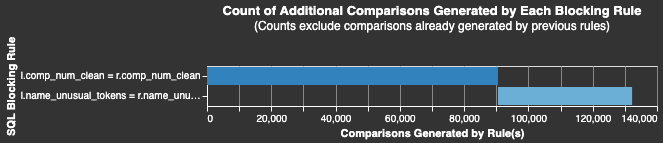

In [44]:
linker_2.cumulative_num_comparisons_from_blocking_rules_chart(
    list(blocking_rules_2.values())
)

The plan of attack for Monday:

* Begin testing the blocking rules and combinations of the blocking rules. Ideas:
    * Match comp_num_clean OR name_unusual_tokens
        * Is OR functionally different to the ANY rule splink uses for separate rules?
    * Match comp_num_clean OR name_unusual_tokens OR postcode
* Find some way to evaluate the quality of my choices
* Think about any obvious wins that might improve the match process
* Bring in some other datasets (we can enumerate them while stuff runs)

> More generally, we can often specify multiple blocking rules such that it becomes highly implausible that a true match would not meet at least one of these blocking critera. This is the recommended approach in Splink. Generally we would recommend between about 3 and 10, though even more is possible.